In [49]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import time
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score
from torchinfo import summary
import warnings
import os 
warnings.filterwarnings('ignore') 

In [50]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Mean and Standard deviation were calculated in separate snippet code

In [51]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),
    transforms.Normalize((0.1758,), (0.3270,))
])

In [52]:
data = datasets.ImageFolder(root='cnn_dataset', transform=transform)

In [53]:
print("Length of clases:",len(data.classes))

Length of clases: 36


In [54]:
trainRatio = 0.8
valRatio = 0.1
testRatio = 0.1
trainSize = int(trainRatio * len(data))
valSize = int(valRatio * len(data))
testSize = len(data) - trainSize - valSize

trainData, valData, testData = random_split(data, [trainSize, valSize, testSize])
batch_size = 32
trainDataLoader = DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=4)
valDataLoader = DataLoader(valData, batch_size=batch_size, shuffle=False, num_workers=4)
testDataLoader = DataLoader(testData, batch_size=batch_size, shuffle=False, num_workers=4)


In [68]:
import torch
import torch.nn as nn

class VGG13Grayscale(nn.Module):
    def __init__(self, num_classes=36):
        super(VGG13Grayscale, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
            
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)  
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)  
                nn.init.constant_(m.bias, 0)

num_classes = 36
model = VGG13Grayscale(num_classes=num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.time()
model = model.to(device)
num_epochs = 15
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainDataLoader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() 

      
        outputs = model(images)
        loss = criterion(outputs, labels)

        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss / len(trainDataLoader))

   
    model.eval() 
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in valDataLoader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

   
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss / len(valDataLoader))

   
    scheduler.step()

    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%")

torch.save(model.state_dict(), 'nikhil_kiran_assignment2_part4.pt')  

end_time = time.time()
print(f"Total Training Time: {end_time - start_time:.2f} seconds")
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Epoch [1/15], Train Loss: 1.5166, Train Acc: 55.42%, Val Loss: 0.3603, Val Acc: 86.94%
Epoch [2/15], Train Loss: 0.3259, Train Acc: 88.34%, Val Loss: 0.2925, Val Acc: 89.20%
Epoch [3/15], Train Loss: 0.2534, Train Acc: 90.42%, Val Loss: 0.2759, Val Acc: 90.25%
Epoch [4/15], Train Loss: 0.2180, Train Acc: 91.51%, Val Loss: 0.2538, Val Acc: 90.78%
Epoch [5/15], Train Loss: 0.1947, Train Acc: 92.25%, Val Loss: 0.2548, Val Acc: 90.60%
Epoch [6/15], Train Loss: 0.1464, Train Acc: 93.84%, Val Loss: 0.2267, Val Acc: 91.88%
Epoch [7/15], Train Loss: 0.1348, Train Acc: 94.24%, Val Loss: 0.2257, Val Acc: 92.05%
Epoch [8/15], Train Loss: 0.1290, Train Acc: 94.47%, Val Loss: 0.2298, Val Acc: 92.03%
Epoch [9/15], Train Loss: 0.1247, Train Acc: 94.63%, Val Loss: 0.2308, Val Acc: 91.95%
Epoch [10/15], Train Loss: 0.1207, Train Acc: 94.79%, Val Loss: 0.2369, Val Acc: 92.06%
Epoch [11/15], Train Loss: 0.1144, Train Acc: 95.07%, Val Loss: 0.2392, Val Acc: 92.05%
Epoch [12/15], Train Loss: 0.1140, Train 

In [71]:
model.eval()
testLoss = 0.0
correctPredictions = 0
predictions = []
yTrue = []
test_accuracies=[]

with torch.no_grad():
    for images, labels in testDataLoader:
        images, labels = images.to(device), labels.to(device) 

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        testLoss += loss.item()  

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correctPredictions += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        yTrue.extend(labels.cpu().numpy())


testLoss /= len(testDataLoader)
test_accuracy = correctPredictions / len(testData)
test_accuracies.append(test_accuracy)

print(f"Test Loss: {testLoss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.2421, Test Accuracy: 92.47%


In [72]:
print(f"Length of train_accuracies: {len(train_accuracies)}")
print(f"Length of val_accuracies: {len(val_accuracies)}")
print(f"Length of test_accuracies: {len(test_accuracies)}") 


Length of train_accuracies: 15
Length of val_accuracies: 15
Length of test_accuracies: 1


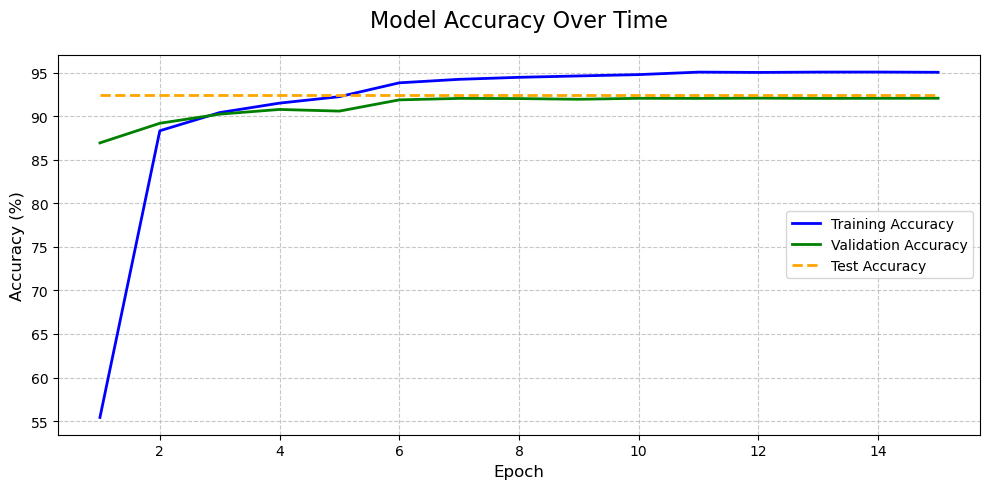

In [77]:
plt.figure(figsize=(10, 5))

epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue', linewidth=2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
plt.plot([1, len(epochs)], [test_accuracy*100, test_accuracy*100], 'r--', 
         label='Test Accuracy', color='orange', linewidth=2)

plt.title('Model Accuracy Over Time', fontsize=16, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='center right')

plt.tight_layout()

plt.show()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000216F09F1AB0>
Traceback (most recent call last):
  File "C:\Users\kiran\anaconda3\envs\old\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\kiran\anaconda3\envs\old\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


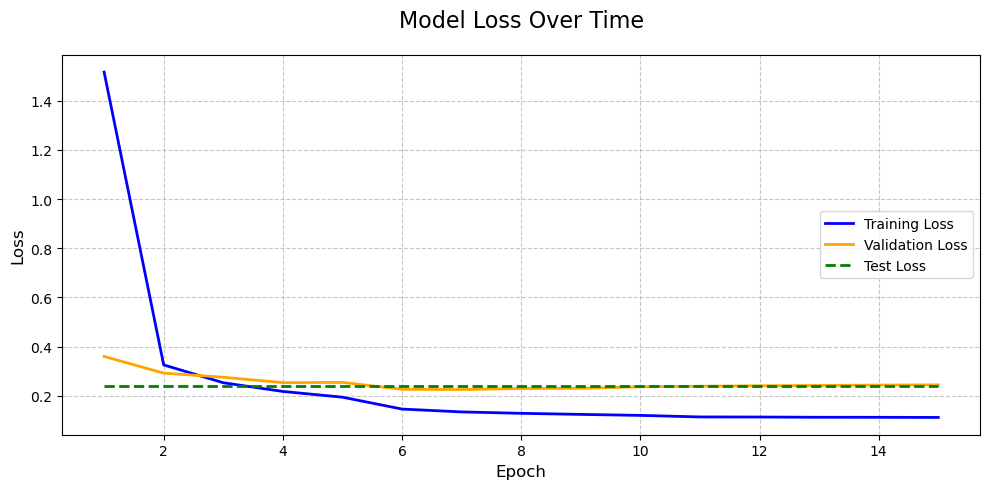

In [78]:
plt.figure(figsize=(10, 5))

epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training Loss',color='blue', linewidth=2)
plt.plot(epochs, val_losses, label='Validation Loss',color='orange', linewidth=2)
plt.plot([1, len(epochs)], [testLoss, testLoss], 'r--', label='Test Loss',color='green', linewidth=2)

plt.title('Model Loss Over Time', fontsize=16, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='center right')

plt.tight_layout()
plt.show()


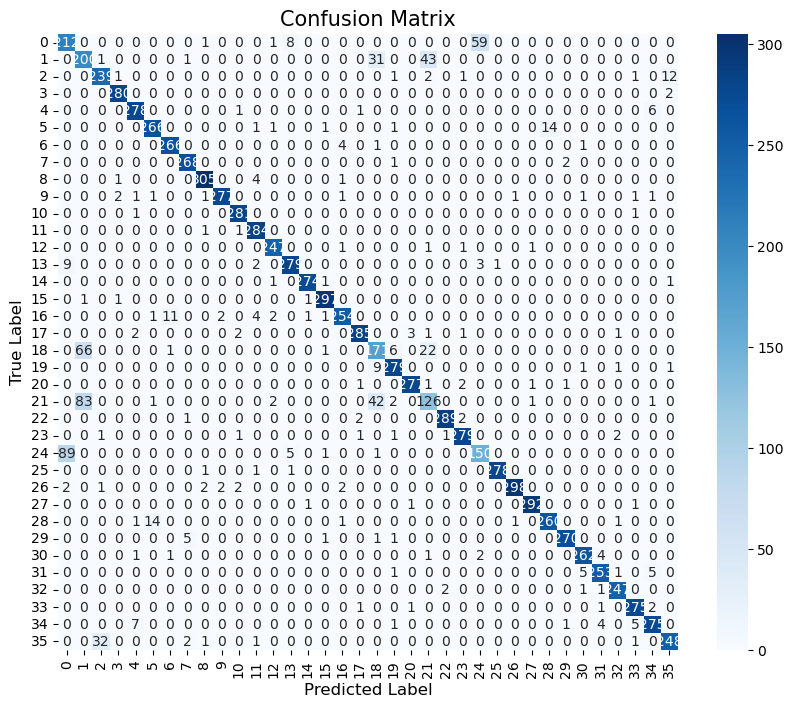

In [75]:
conf_matrix = confusion_matrix(yTrue, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.show()


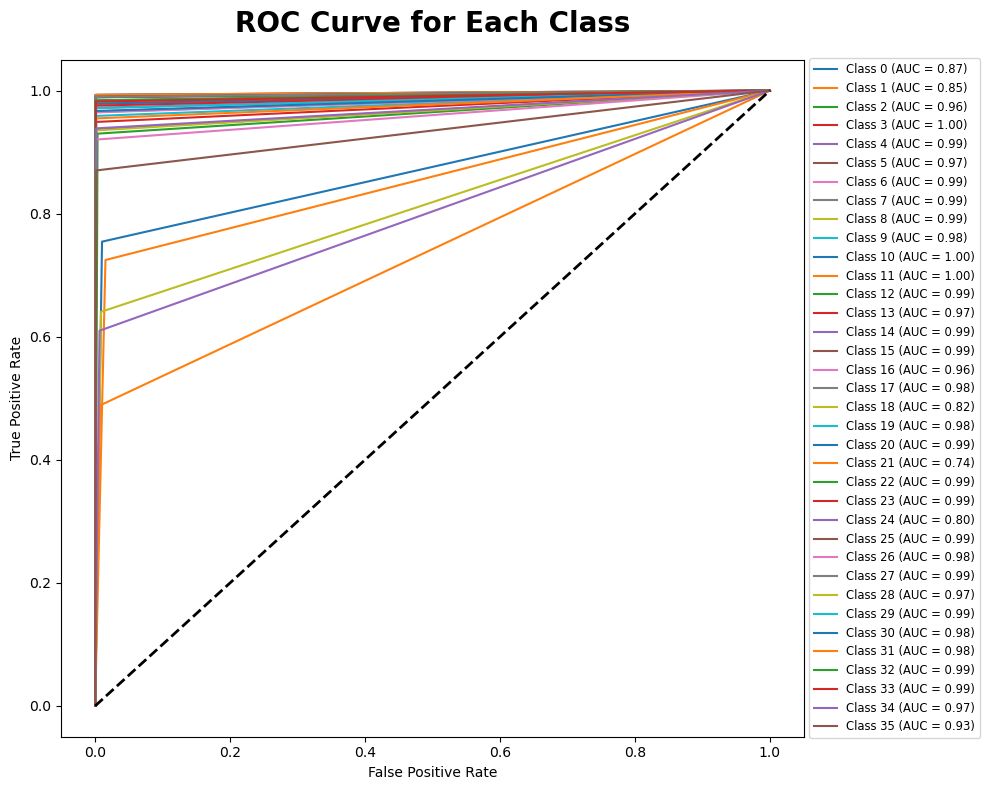

In [76]:
n_classes = len(data.classes)
y_true_binarized = label_binarize(yTrue, classes=range(n_classes))
y_score_binarized = label_binarize(predictions, classes=range(n_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class', fontsize=20, pad=20, weight='bold')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize='small')
plt.tight_layout()
plt.show()
